In [30]:
import sqlalchemy as sql
import os
from dotenv import load_dotenv
import networkx as nx
from matplotlib import pyplot as plt
load_dotenv()

FOCUS_CHANNEL = 'caedrel'

In [31]:
#Connect to database
engine = sql.create_engine(os.environ.get("DB_URL"))
metadata_obj = sql.MetaData()
overlaps_table = sql.Table("channel_overlaps", metadata_obj, autoload_with=engine)

c:\Code\VisualizingTwitchCommunities\env\lib\site-packages\cockroachdb\sqlalchemy\dialect.py:376: SAWarning: Dialect cockroachdb:psycopg2 will not make use of SQL compilation caching as it does not set the 'supports_statement_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Dialect maintainers should seek to set this attribute to True after appropriate development and testing for SQLAlchemy 1.4 caching support.   Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  return super(CockroachDBDialect, self).get_pk_constraint(conn, table_name, schema, **kw)


In [32]:
#Get graph for specified batch
batch_id = 7
stmt = sql.select(overlaps_table.c.source, overlaps_table.c.target, overlaps_table.c.weight).where(overlaps_table.c.batch_id == batch_id)
with engine.connect() as conn:
    edges = conn.execute(stmt).fetchall()

# Create network
network_data = [(source, target, {'weight': weight}) for source, target, weight in edges]
G = nx.from_edgelist(network_data)

In [33]:
#Helper function to get the n highest overlap edges for a particular channel
def get_top_n_edges(edges, channel, n):
    focus_edges = [edge for edge in edges if edge[0] == channel or edge[1] == channel]
    focus_edges = sorted(focus_edges, key=lambda x: x[2], reverse=True)
    return focus_edges[:n]

In [34]:
#Discover channels to be put on graph
decays = [100, 10] #Find 100 highest overlaps, then find highest 10 overlaps for each channel discovered
depth = len(decays)

#Keep track of which level of decay channels were discovered at
orbits = [[] for _ in range(depth + 1)]
orbits[0].append(FOCUS_CHANNEL)

discovered_channels = set()
discovered_channels.add(FOCUS_CHANNEL)

filtered_edgelist = []

#Discover channels and edges
for level in range(depth):
    n = decays[level]
    for channel in orbits[level]:
        discovered_edges = get_top_n_edges(edges, channel, n)
        for edge in discovered_edges:
            linked_channel = edge[0]
            if edge[0] == channel:
                linked_channel = edge[1]

            assert(linked_channel != channel)

            filtered_edgelist.append((channel, linked_channel, edge[2]))
            if(linked_channel not in discovered_channels):
                orbits[level+1].append(linked_channel)
                discovered_channels.add(linked_channel)

In [35]:
len(filtered_edgelist)

1100

In [36]:
#Map from channel name to orbit (Orbits are the level of connection to FOCUS_CHANNEL. FOCUS_CHANNEL will have a value of 0)
channel_orbit_map = {}
for i in range(len(orbits)):
    for channel in orbits[i]:
        channel_orbit_map[channel] = i

In [37]:
#Filter original graph to only discovered channels 
def filter_node(n1):
    return n1 in discovered_channels

network_data = [(source, target, {'weight': weight}) for source, target, weight in filtered_edgelist]
F = nx.subgraph_view(G, filter_node=filter_node)
len(F.nodes())

186

In [38]:
#Get channel info for watch hours
channels_table = sql.Table("channels", metadata_obj, autoload_with=engine)
stmt = sql.select(channels_table.c.url_name, channels_table.c.view_minutes)
with engine.connect() as conn:
    res = conn.execute(stmt).fetchall()

#Create map from channel to watch hours
channel_watch_mins_map = {channel: {'watch_minutes': watch_minutes} for channel, watch_minutes in res}

In [26]:
#Filter all edges that do not connect to FOCUS_CHANNEL only keeping those above non_focus_threshold 
non_focus_threshold = 10000
cutoff_edges = []
X = F.copy()
for u,v,d in X.edges(data=True):
    if(u == FOCUS_CHANNEL):
        is_focus_edge = True
    elif(v == FOCUS_CHANNEL):
        is_focus_edge = True
    else:
        is_focus_edge = False
    
    if(not is_focus_edge and d['weight'] < non_focus_threshold):
        cutoff_edges.append((u,v))

    
    
print(len(cutoff_edges))
X.remove_edges_from(cutoff_edges)
F = X

14550


ValueError: s must be a scalar, or float array-like with the same size as x and y

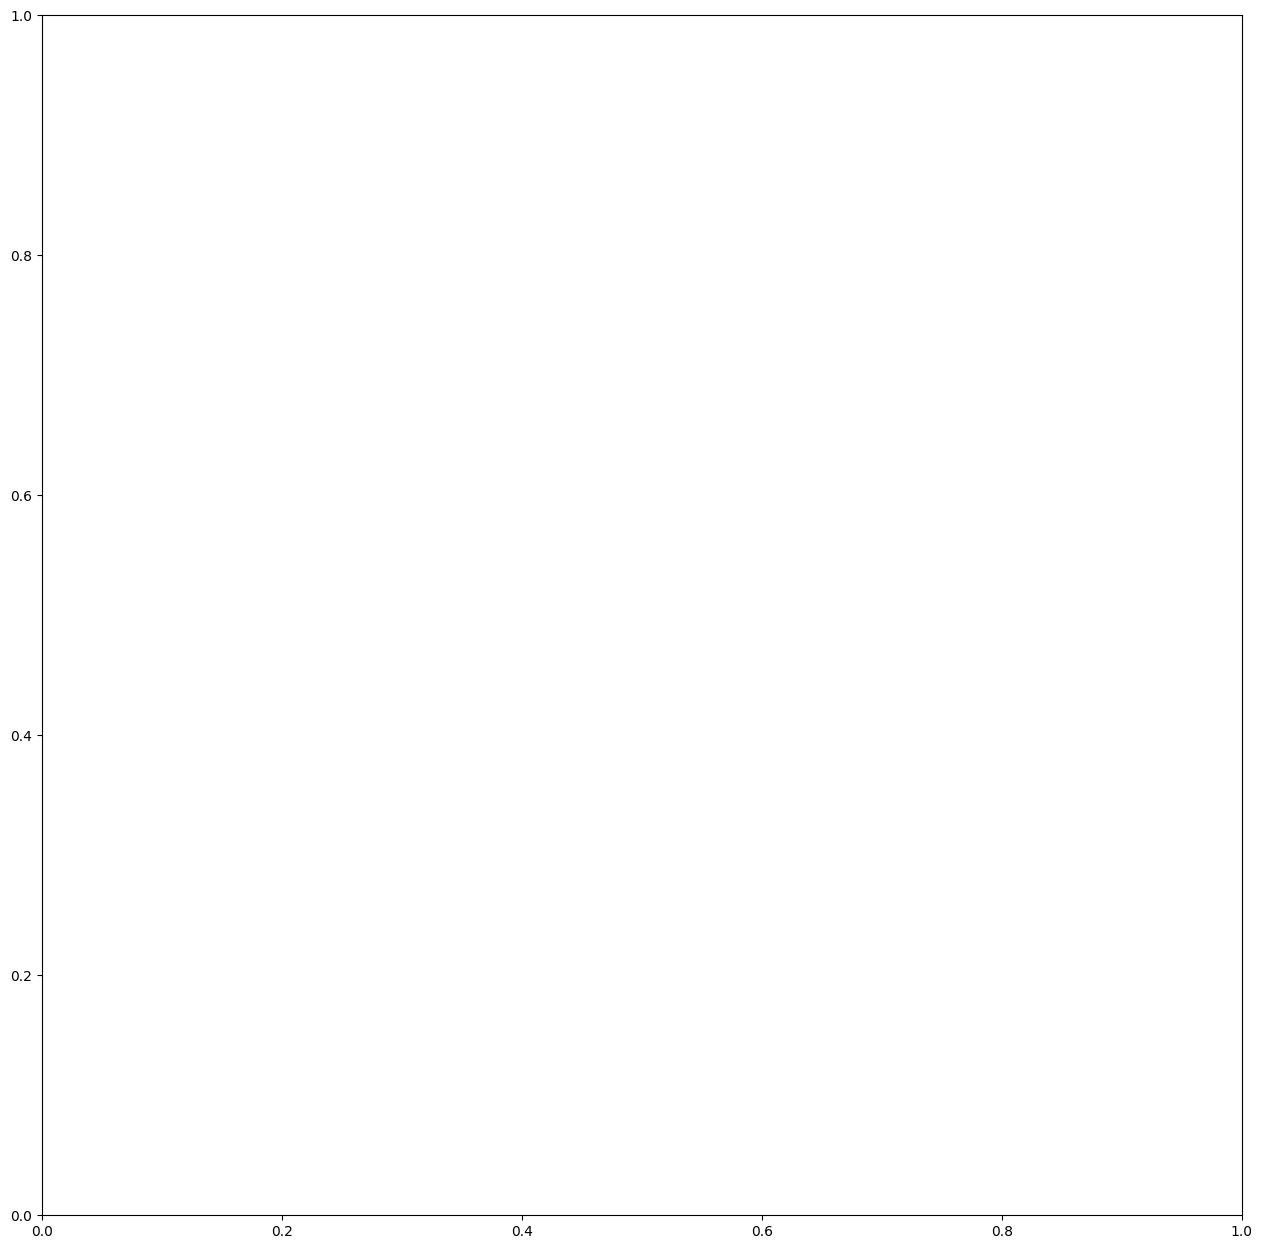

In [29]:
#Draw graph for testing
d = nx.get_node_attributes(F, "watch_minutes")
pos = nx.fruchterman_reingold_layout(F, k = 10, iterations=1000)
edges = F.edges()
weights = [F[u][v]['weight'] for u,v in edges]

plt.figure(3,figsize=(12,12))
nx.draw(F, pos, node_size=[v * 0.000001 for v in d.values()], width=[w * 0.0001 for w in weights], with_labels=True)

In [39]:
#Write edgelist csv
nx.write_edgelist(F, f'{FOCUS_CHANNEL}_graph.csv', delimiter=', ', data=['weight'])

#Write nodelist csv
csv_data = [(name, name, size, channel_orbit_map[name], 3 - channel_orbit_map[name]) for name, size in res if name in discovered_channels]
import csv
with open(f'{FOCUS_CHANNEL}_nodes.csv', 'w') as handle:
    writer = csv.writer(handle)
    writer.writerow(['id', 'label', 'size', 'orbit', 'orbit_size'])
    writer.writerows(csv_data)

In [40]:
#Calculate Reach (Unique chatters in data range)
range_start = '2022-11-01 00:00:00'
range_end = '2022-11-15 00:00:00'

chatters_table = sql.Table("chatters", metadata_obj, autoload_with=engine)


In [41]:
channel_uv_map = {}
counter = 0 
for channel in discovered_channels:
    print(f"Getting unique viewer set for {channel}, {counter}/{len(discovered_channels)}")
    stmt = sql.select(chatters_table.c.chatters_json).where( \
        (chatters_table.c.url_name == channel) & \
        (chatters_table.c.log_time > range_start) & \
        (chatters_table.c.log_time < range_end))
    
    with engine.connect() as conn:
        all_chatters = conn.execute(stmt).fetchall()
    
    num_unique_viewers = set()
    for chatters in all_chatters:

        chatters = chatters[0]['chatters']
        num_unique_viewers = num_unique_viewers.union(chatters)
    
    channel_uv_map[channel] = len(num_unique_viewers)
    counter += 1

Getting unique viewer set for sneakylol, 0/186
Getting unique viewer set for 39daph, 1/186
Getting unique viewer set for teamfighttactics, 2/186
Getting unique viewer set for dannyaarons, 3/186
Getting unique viewer set for primeleague, 4/186
Getting unique viewer set for moistcr1tikal, 5/186
Getting unique viewer set for admiralbahroo, 6/186
Getting unique viewer set for esl_csgob, 7/186
Getting unique viewer set for emongg, 8/186
Getting unique viewer set for nix, 9/186
Getting unique viewer set for disguisedtoast, 10/186
Getting unique viewer set for rocketleaguesam, 11/186
Getting unique viewer set for folagorlives, 12/186
Getting unique viewer set for pgl_dota2en4, 13/186
Getting unique viewer set for otknetwork, 14/186
Getting unique viewer set for mynthos, 15/186
Getting unique viewer set for lacari, 16/186
Getting unique viewer set for staysafetv, 17/186
Getting unique viewer set for solary, 18/186
Getting unique viewer set for otplol_, 19/186
Getting unique viewer set for trai

In [52]:
reach_csv_data = []
for channel, unique_viewers in channel_uv_map.items():
    reach_csv_data.append([channel, unique_viewers])

import csv
with open(f'{FOCUS_CHANNEL}_reach.csv', 'w') as handle:
    writer = csv.writer(handle)
    writer.writerow(['Channel', 'Unique Viewer Count'])
    writer.writerows(reach_csv_data)